In [2]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [3]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [4]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 109)


In [25]:

cn = 'voice_capture_message'
mask_series = frvrs_logs_df[cn].isnull()
# sorted([vc for vc in frvrs_logs_df[~mask_series][cn]], key=lambda x: len(x))[-10:]
srs = frvrs_logs_df[~mask_series][cn].value_counts()
mask_series = srs.index.map(lambda x: len(x) > 25)
srs[mask_series].head(10)

are you hurt anywhere else                     16
do you have any other injuries                 13
if you can hear me wave your hand               9
are you hurting anywhere else                   7
anybody that can wave wave                      6
have you heard anywhere else                    5
sir can you tell me your name                   5
if you can hear my voice I want you to wave     4
if you can hear my voice wave                   4
are you injured anywhere else                   4
Name: voice_capture_message, dtype: int64


# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)



## Did they get it right?

In [4]:

# Show all combinations of the treated/wrongly columns
columns_list = [
    'injury_record_injury_treated_with_wrong_treatment', 'injury_record_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = frvrs_logs_df[columns_list].drop_duplicates()
for cn in columns_list:
    print()
    print(cn)
    display(df[cn].unique().tolist())
    # mask_series = ~frvrs_logs_df[cn].isnull()
    # display(frvrs_logs_df[mask_series].sample(min(4, frvrs_logs_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)


injury_record_injury_treated_with_wrong_treatment


[nan, False]


injury_record_injury_treated


[nan, False]


injury_treated_injury_treated_with_wrong_treatment


[nan, False, True]


injury_treated_injury_treated


[nan, True, False]

In [5]:

if nu.pickle_exists('patient_count_df'):
    patient_count_df = nu.load_object('patient_count_df')
else:
    
    # Create a list of the columns to group by
    groupby_columns = ['session_uuid', 'time_group', 'patient_id']
    
    # Group the frvrs_logs_df dataframe by the groupby columns
    gb = frvrs_logs_df.sort_values(['elapsed_time']).groupby(groupby_columns)
    
    # Initialize an empty list to store rows
    rows_list = []
    
    # Iterate over the grouped dataframe
    for (session_uuid, time_group, patient_id), df1 in gb:
        
        # Get the logger version for the current group
        logger_version = df1.logger_version.unique().item()
    
        # Iterate over the possible values for the two columns
        for wrong in [True, False]:
            for eventually in [True, False]:
                
                # Create a dictionary to store the results for the current group
                row_dict = {}
                
                # Add the logger version to the row dictionary
                row_dict['logger_version'] = logger_version
                
                # Populate the row_dict with values from the groupby_columns
                for cn in groupby_columns: row_dict[cn] = eval(cn)
                
                # Add the current values of the two columns to the row dictionary
                row_dict['injury_treated_injury_treated_with_wrong_treatment'] = wrong
                row_dict['injury_treated_injury_treated'] = eventually
    
                # Initialize a filter rows to add conditions via a loop
                mask_series = True
    
                # Add conditions for each column in groupby_columns
                for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
                
                # Add the two columns to the mask series
                mask_series &= (frvrs_logs_df.injury_treated_injury_treated_with_wrong_treatment == wrong)
                mask_series &= (frvrs_logs_df.injury_treated_injury_treated == eventually)
    
                # Calculate the unique patient count for the filtered rows
                row_dict['patient_count'] = frvrs_logs_df[mask_series].patient_id.unique().shape[0]
    
                # Add the row dictionary to the rows list
                rows_list.append(row_dict)
    
    # Create a DataFrame from the list of rows
    patient_count_df = DataFrame(rows_list)
    nu.store_objects(patient_count_df=patient_count_df)

In [6]:

# Get the distribution of wrong treatments
mask_series = (patient_count_df.patient_count > 0)
columns_list = [
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = patient_count_df[mask_series]
display(df[columns_list].drop_duplicates())
display(df.sample(min(4, patient_count_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
display(df.groupby(columns_list).sum().patient_count.to_frame())
mask_series = (df.injury_treated_injury_treated == True)
display(df[mask_series].groupby('injury_treated_injury_treated_with_wrong_treatment').sum().patient_count.to_frame())

,injury_treated_injury_treated_with_wrong_treatment,injury_treated_injury_treated
4,True,True
5,True,False
54,False,True


,17590,14166,36260,38154
logger_version,1.3,1.0,1.3,1.3
session_uuid,71197277-ba36-4a82-9ae0-0016e7756665,5c8b0274-379c-40ca-b6ff-b846f9e14ad5,eb641af4-13da-4e13-a5dd-02eb0e7e6c23,f7d9738a-35c1-4af0-8e98-5bf3a1cff310
time_group,1,2,2,2
patient_id,Mike_3 Root,Gloria_8 Root,Mike_5 Root,Mike_5 Root
injury_treated_injury_treated_with_wrong_treatment,False,False,True,False
injury_treated_injury_treated,True,True,True,True
patient_count,1,1,1,1


patient_count
injury_treated_injury_treated_with_wrong_treatment injury_treated_injury_treated               
False                                              True                                    2971
True                                               False                                    503
                                                   True                                     373

,patient_count
injury_treated_injury_treated_with_wrong_treatment,
False,2971
True,373


In [7]:

if nu.pickle_exists('rightly_treated_count_df'):
    rightly_treated_count_df = nu.load_object('rightly_treated_count_df')
else:
    
    # Get the distribution of right treatments
    groupby_columns = ['session_uuid', 'time_group']
    
    # Group the patient count data frame by the groupby columns
    gb = patient_count_df.groupby(groupby_columns)
    
    # Initialize an empty list to store rows
    rows_list = []
    
    # Iterate over the grouped dataframe
    for (session_uuid, time_group), df1 in gb:
        
        # Create a dictionary to store the results for the current group
        row_dict = {}
        
        # Get the logger version for the current group
        logger_version = df1.logger_version.unique().item()
        
        # Add the logger version to the row dictionary
        row_dict['logger_version'] = logger_version
        
        # Populate the row_dict with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
        
        # Count all the patients up
        mask_series = True
        for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        row_dict['patient_count'] = frvrs_logs_df[mask_series].patient_id.unique().shape[0]
        
        # Create a filter to get all treated patients and count them up
        mask_series = (df1.injury_treated_injury_treated == True)
        row_dict['treated_count'] = df1[mask_series].patient_count.sum()
        
        # Create a filter to get all rightly treated patients and count them up
        mask_series = (df1.injury_treated_injury_treated == True) & (df1.injury_treated_injury_treated_with_wrong_treatment == False)
        row_dict['rightly_treated_count'] = df1[mask_series].patient_count.sum()
        
        # Create a filter to get all wrongly treated patients and count them up
        mask_series = (df1.injury_treated_injury_treated_with_wrong_treatment == True)
        row_dict['mistaken_attempts_count'] = df1[mask_series].patient_count.sum()
        
        # Add the row dictionary to the rows list
        rows_list.append(row_dict)
    
    # Create a DataFrame from the list of rows
    rightly_treated_count_df = DataFrame(rows_list)
    nu.store_objects(rightly_treated_count_df=rightly_treated_count_df)

In [8]:

# Visualize some mistaken attempts
mask_series = (rightly_treated_count_df.mistaken_attempts_count > 0)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,937,381,245,202
logger_version,1.0,1.3,1.3,1.0
session_uuid,e2ddf563-3583-404c-917a-8eb7bec38471,5d916938-e0d3-47ee-8f55-12bf12283ee1,33f3d2d4-49b4-43cf-80d4-cd7d5993aca4,2d511693-6144-45ee-89df-aba0ca629c84
time_group,2,1,1,1
patient_count,12,11,13,13
treated_count,5,1,4,4
rightly_treated_count,5,1,3,3
mistaken_attempts_count,1,1,1,2


In [9]:

# Are there more treated patients than possible?
mask_series = (rightly_treated_count_df.treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


In [10]:

# Are there more rightly treated patients than treated patients?
mask_series = (rightly_treated_count_df.rightly_treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


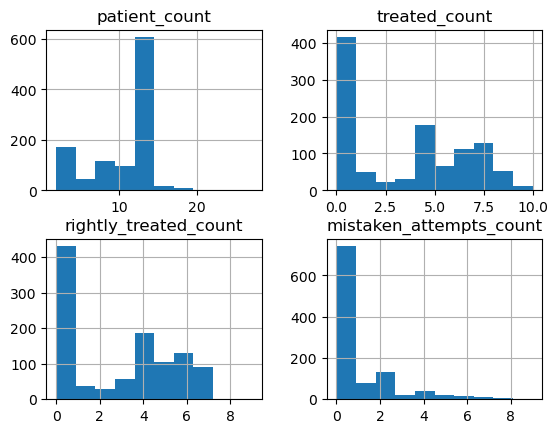

In [11]:

# Visualize histograms of all the distributions
columns_list = ['patient_count', 'treated_count', 'rightly_treated_count', 'mistaken_attempts_count']
rightly_treated_count_df[columns_list].hist();



## Did they do it in the right order?

(Red, Gray, Black), then wavers, then walkers last

In [12]:

# Investigate the presence of black
srs = frvrs_logs_df.applymap(lambda x: 'black' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']

In [13]:

# Investigate the presence of wave
srs = frvrs_logs_df.applymap(lambda x: 'wave' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['action_type', 'patient_demoted_sort', 'voice_capture_message', 'voice_command_message', 'voice_command_command_description', 'patient_record_sort', 's_a_l_t_wave_if_can_sort_command_text', 's_a_l_t_waved_sort_command_text', 'patient_engaged_sort']


### Adjusted R-squared

I am using the adjusted R-squared value of a linear regression model fit as a measure of how well trainees engaged the still first, then wavers, then walkers last. A score of 1.0 will mean that the trainee performed the ideal sequence. A score of -1.0 means that the trainee performed the opposite sequence.

The algorithm will work for any number of patients. It allows for any number of still patients, which will be correctly placed in the beginning of the ideal sequence. The numbers are just the milliseconds of elapsed time at the engagement of a patient. The time groups are zero-indexed _SESSION_START_ to _SESSION_END_ segments. Time group 1 is the 2nd session in the file, for instance.

This is possibly also a measure of Tolerance for Risk (see https://nextcentury.atlassian.net/wiki/spaces/ITMC/pages/2998960129/KDMAs).

In [5]:

# Create a dataset of measures of right ordering
import statsmodels.api as sm

if nu.pickle_exists('engagment_sort_df'):
    engagment_sort_df = nu.load_object('engagment_sort_df')
else:
    groupby_columns = ['session_uuid', 'time_group']
    gb = frvrs_logs_df.groupby(groupby_columns)
    rows_list = []
    for (session_uuid, time_group), df1 in gb:
        row_dict = {}
        
        # Add the logger version for the current group
        logger_version = df1.logger_version.unique().item()
        row_dict['logger_version'] = logger_version
        
        # Populate the row_dict with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
    
        # Get the last engagement time among all the obvious life threats
        assert ('tag_applied_type' in df1.columns)
        mask_series = df1.tag_applied_type.isin(['red', 'gray', 'black'])
        df = df1[mask_series]
        if df.shape[0]:
            # display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
            patient_ids_list = df.patient_id.unique().tolist()
            mask_series = True
            for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
            mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
            row_dict['last_threat_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
    
        # Group the patients by engagement SORT category and get lists of their elapsed times
        engaged_sort_dict = {}
        for patient_engaged_sort, df2 in df1.groupby('patient_engaged_sort'):
            if patient_engaged_sort in ['still', 'waver', 'walker']:
                patient_ids_list = df2.patient_id.unique().tolist()
                mask_series = True
                for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
                mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
                mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
                row_dict[f'last_{patient_engaged_sort}_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
                engaged_sort_dict[patient_engaged_sort] = frvrs_logs_df[mask_series].sort_values('elapsed_time').elapsed_time.tolist()
        
        # Get an R-squared Adjusted as a measure of right ordering
        # if (session_uuid == '7de52180-d823-4f9e-9003-aeab8139970b') and (time_group == 1): raise
        ideal_sequence = []
        for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
        ideal_sequence = pd.Series(data=ideal_sequence)
        actual_sequence = ideal_sequence.sort_values(ascending=True)
        X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
        if X.shape[0]:
            X1 = sm.add_constant(X)
            try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
            except: rsquared_adj = np.nan
            row_dict['rsquared_adj'] = rsquared_adj
        
        rows_list.append(row_dict)
    
    engagment_sort_df = DataFrame(rows_list)
    nu.store_objects(engagment_sort_df=engagment_sort_df)

In [7]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
display(engagment_sort_df.sample(min(4, engagment_sort_df.shape[0])).dropna(axis='columns', how='all').T)

,157,658,1047,411
logger_version,1.3,1.0,1.3,1.0
session_uuid,21526c63-79bb-4c7b-87c2-9e7525d8515f,992d4672-7993-44ba-890c-0d8605ccefdd,f5dafd5d-461d-4440-9e3b-1b1c899df9e4,5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0
time_group,0,1,2,0
last_threat_engaged,NaN,129498.0,793860.0,NaN
last_walker_engaged,NaN,167820.0,742463.0,NaN
rsquared_adj,NaN,1.0,0.856928,NaN
last_still_engaged,NaN,34752.0,453474.0,NaN
last_waver_engaged,NaN,86436.0,813266.0,NaN
stills_finished_first,NaN,True,True,NaN



Here is a histogram of the values:

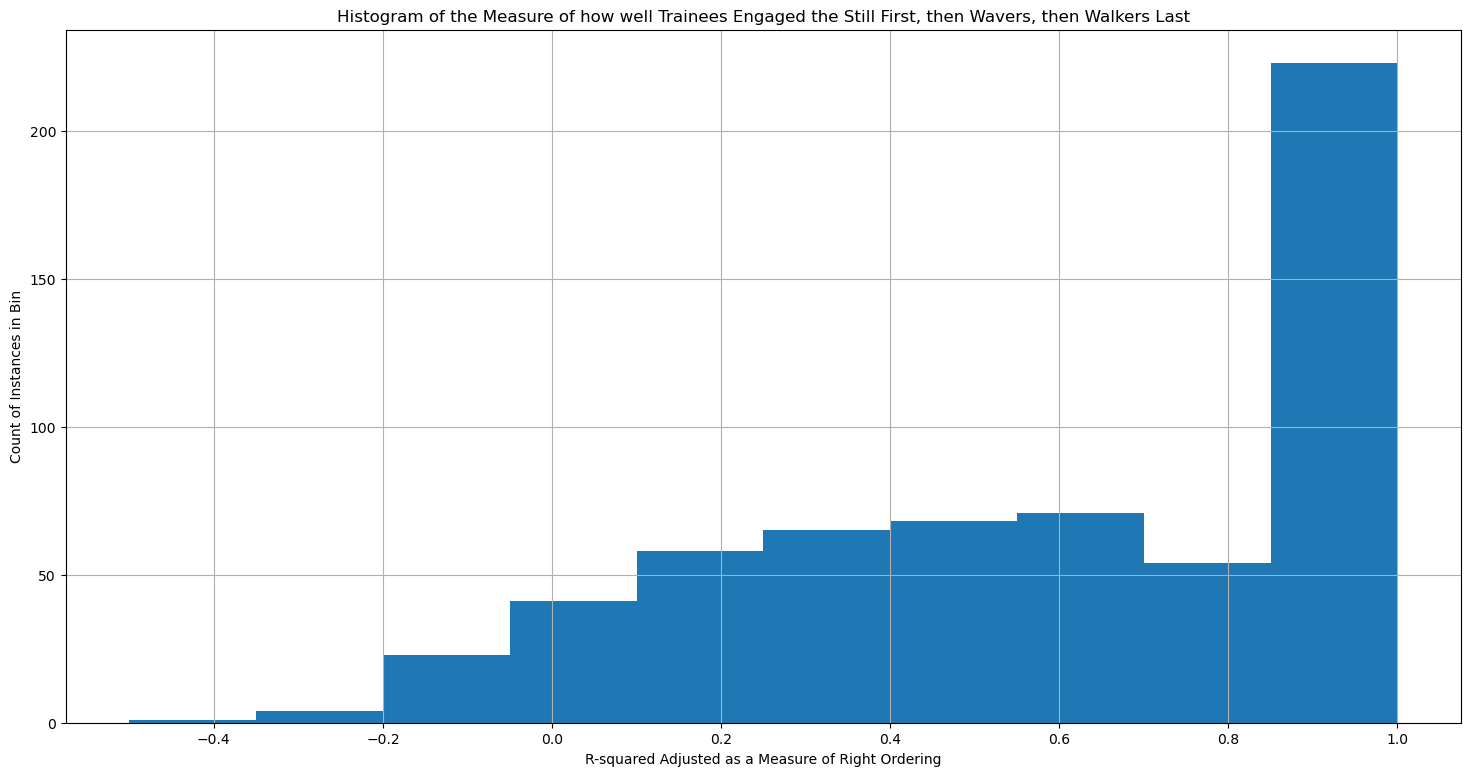

In [14]:

# Display a histogram of the distribution of the measure of
# how well trainees engaged the still first, then wavers, then walkers last
fig, ax = plt.subplots(figsize=(18, 9))
engagment_sort_df.rsquared_adj.hist(ax=ax)

# Humanize x tick labels
# xticklabels_list = []
# for text_obj in ax.get_xticklabels():
#     text_obj.set_text(
#         text_obj.get_position()[0]
#     )
#     xticklabels_list.append(text_obj)
# ax.set_xticklabels(xticklabels_list)

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.intword(int(text_obj.get_position()[1]))
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Set the title and labels
ax.set_title('Histogram of the Measure of how well Trainees Engaged the Still First, then Wavers, then Walkers Last')
ax.set_xlabel('R-squared Adjusted as a Measure of Right Ordering')
ax.set_ylabel('Count of Instances in Bin');


#### Edge cases

The worst-case scenario is displayed as the blue vertical bar at the far left of the histogram. The best-case scenario is a component of the right-most vertical bar.

In [17]:

# Display a sample of adjusted R-squared at its maximum, dropping columns with all NaN values and transposing it
max_rsquared_adj = engagment_sort_df.rsquared_adj.max()
mask_series = engagment_sort_df.rsquared_adj.isin([max_rsquared_adj])
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,277,522,785,402
logger_version,1.3,1.0,1.3,1.0
session_uuid,37ed31fb-6f8a-4cc0-b80e-ac4138e42405,741e494b-63ff-4ea2-ad88-657f2276045d,b5a82a5b-e259-4d87-bdb7-94f9cb1ce6ea,5dce5abe-7ded-46e7-8d07-b2e2cd76ef55
time_group,2,1,1,1
last_threat_engaged,1005491.0,271506.0,279352.0,143073.0
last_walker_engaged,1005491.0,272859.0,283207.0,157464.0
rsquared_adj,1.0,1.0,1.0,1.0
last_still_engaged,530803.0,89570.0,48755.0,58727.0
last_waver_engaged,778433.0,108946.0,124270.0,116633.0
stills_finished_first,True,True,True,True


In [18]:

# Display a sample of adjusted R-squared at its minimum, dropping columns with all NaN values and transposing it
min_rsquared_adj = engagment_sort_df.rsquared_adj.min()
mask_series = engagment_sort_df.rsquared_adj.isin([min_rsquared_adj])
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,65
logger_version,1.0
session_uuid,0b891add-e0c3-463d-948d-7f491f1d10ef
time_group,4
last_threat_engaged,676501.0
last_walker_engaged,653151.0
rsquared_adj,-0.5
last_still_engaged,676501.0
last_waver_engaged,722393.0
stills_finished_first,False


In [19]:

# In the worse-case scenario, the trainee was supposed to engage the waver first, then the two walkers
# Instead, they engaged one of the walkers, then a waver, then the other walker
session_uuid = '274ce308-c366-4829-b9cc-d535b51d16d3'
time_group = 1
engaged_sort_dict = {'walker': [54614, 102065], 'waver': [88520]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [88520, 54614, 102065]
actual_sequence = [54614, 88520, 102065]
rsquared_adj = -0.9971283921806686


In [20]:

# In the best-case scenario, the trainee was supposed to engage the still first, then the waver, then the walkers
# They executed this in the correct sequence
session_uuid = '7de52180-d823-4f9e-9003-aeab8139970b'
time_group = 1
engaged_sort_dict = {'still': [56434], 'walker': [164294, 195562, 208187, 210397, 211747, 212450, 212649], 'waver': [108854]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [56434, 108854, 164294, 195562, 208187, 210397, 211747, 212450, 212649]
actual_sequence = [56434, 108854, 164294, 195562, 208187, 210397, 211747, 212450, 212649]
rsquared_adj = 1.0



### Stills Finished First

In [21]:

# Verify that the stills were finished first
import numpy as np

def f(df):
    last_still_engaged = df.last_still_engaged
    last_walker_engaged = df.last_walker_engaged
    last_waver_engaged = df.last_waver_engaged
    min_engagement = min(last_still_engaged, last_walker_engaged, last_waver_engaged)

    return (last_still_engaged == min_engagement)
engagment_sort_df['stills_finished_first'] = engagment_sort_df.apply(f, axis='columns')

# Create a mask where any of the last engaged columns are NaN and set the stills finished first column to NaN if true
columns_list = ['last_still_engaged', 'last_walker_engaged', 'last_waver_engaged']
mask_series = engagment_sort_df[columns_list].isnull().any(axis='columns')
engagment_sort_df.loc[mask_series, 'stills_finished_first'] = np.nan

mask_series = (engagment_sort_df.stills_finished_first == False)
df = engagment_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,862,731,466,783
logger_version,1.0,1.0,1.0,1.3
session_uuid,cf953248-e6cf-4544-95ce-4843d0f56f10,ab1f8cd1-8d65-45da-b087-89b25ff46c66,693461dd-b8f6-4c60-92b6-bd1db0ffcac8,b541f5c9-93fe-4ef3-9fe7-38493b8aa8a8
time_group,2,1,1,2
last_threat_engaged,822747.0,748245.0,447319.0,712932.0
last_walker_engaged,770516.0,613587.0,392835.0,681491.0
rsquared_adj,0.516312,0.058678,0.180085,0.446786
last_still_engaged,822747.0,748245.0,447319.0,712932.0
last_waver_engaged,835218.0,735900.0,301317.0,570074.0
stills_finished_first,False,False,False,False
